In [25]:
import requests
from invisibleroads_macros.disk import make_folder
from os.path import expanduser, join

def download(target_path, source_url):
    response = requests.get(source_url)
    open(target_path, 'w').write(response.content)
    return target_path

target_folder = make_folder(expanduser('~/Experiments/spatiotemporal'))
geojson_path = join(target_folder, 'nyc-traffic-injuries.json')
shapefile_path = join(target_folder, 'nyc-traffic-injuries.shp.zip')

In [2]:
geojson_path = download(
    join(target_folder, 'nyc-traffic-injuries.json'), 
    'http://www.nyc.gov/html/dot/downloads/misc/injury_all_monthly.json')
shapefile_path = download(
    join(target_folder, 'nyc-traffic-injuries.shp.zip'),
    'http://www.nyc.gov/html/dot/downloads/misc/injury_all_monthly_shapefile.zip')

In [ ]:
import fiona
geojson_collection = fiona.open(geojson_path)
print 'geojson_collection.bounds = %s' % repr(geojson_collection.bounds)
print 'geojson_collection.crs_wkt = %s' % geojson_collection.crs_wkt
print 'geojson_collection.crs = %s' % geojson_collection.crs
geojson_collection[0]

In [26]:
import fiona
shapefile_collection = fiona.open('/', vfs='zip://' + shapefile_path)
print 'shapefile_collection.bounds = %s' % repr(shapefile_collection.bounds)
print 'shapefile_collection.crs_wkt = %s' % shapefile_collection.crs_wkt
print 'shapefile_collection.crs = %s' % shapefile_collection.crs
shapefile_collection[0]

shapefile_collection.bounds = (-74.2539230306024, 40.49947769792743, -73.70059800086655, 40.91246913562538)
shapefile_collection.crs_wkt = GEOGCS["GCS_WGS_1984",DATUM["WGS_1984",SPHEROID["WGS_84",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]
shapefile_collection.crs = {'init': u'epsg:4326'}


{'geometry': {'coordinates': (-73.7917447266822, 40.72578884918672),
  'type': 'Point'},
 'id': '0',
 'properties': OrderedDict([(u'Injuries', 2),
              (u'PedInjurie', 1),
              (u'BikeInjuri', 0),
              (u'MVOInjurie', 1),
              (u'MN', u'1'),
              (u'YR', u'2009')]),
 'type': 'Feature'}

In [27]:
from pandas import DataFrame, Period
rows, indices = [], []
for value_by_key in shapefile_collection:
    indices.append(int(value_by_key['id']))
    longitude, latitude = map(float, value_by_key['geometry']['coordinates'])
    properties = value_by_key['properties']
    year, month = int(properties['YR']), int(properties['MN'])
    total_injury_count = int(properties['Injuries'])
    pedestrian_injury_count = int(properties['PedInjurie'])
    bike_injury_count = int(properties['BikeInjuri'])
    motor_vehicle_occupant_injury_count = int(properties['MVOInjurie'])
    rows.append([
        longitude, latitude, year, month,
        total_injury_count, pedestrian_injury_count, bike_injury_count, motor_vehicle_occupant_injury_count,
    ])
nyc_traffic_injuries_table = DataFrame(rows, index=indices, columns=[
    'Longitude', 'Latitude', 'Year', 'Month',
    'Total Injury Count', 'Pedestrian Injury Count', 'Bike Injury Count', 'Motor Vehicle Occupant Injury Count',
])
print(nyc_traffic_injuries_table.dtypes)

Longitude                              float64
Latitude                               float64
Year                                     int64
Month                                    int64
Total Injury Count                       int64
Pedestrian Injury Count                  int64
Bike Injury Count                        int64
Motor Vehicle Occupant Injury Count      int64
dtype: object


In [28]:
from os.path import expanduser
nyc_traffic_injuries_table.to_msgpack(expanduser('~/Experiments/spatiotemporal/nyc-traffic-injuries.msg-blosc'), compress='blosc')
nyc_traffic_injuries_table.to_msgpack(expanduser('~/Experiments/spatiotemporal/nyc-traffic-injuries.msg-zlib'), compress='zlib')

In [15]:
from os.path import expanduser
from pandas import read_msgpack

In [29]:
timeit nyc_traffic_injuries_table = read_msgpack(expanduser('~/Experiments/spatiotemporal/nyc-traffic-injuries.msg-blosc'))

100 loops, best of 3: 9.21 ms per loop


In [30]:
timeit nyc_traffic_injuries_table = read_msgpack(expanduser('~/Experiments/spatiotemporal/nyc-traffic-injuries.msg-zlib'))

10 loops, best of 3: 39.5 ms per loop


In [31]:
from os.path import expanduser
from pandas import read_msgpack
nyc_traffic_injuries_table = read_msgpack(expanduser('~/Experiments/spatiotemporal/nyc-traffic-injuries.msg-blosc'))
print 'nyc_traffic_injury_count = %s' % len(nyc_traffic_injuries_table)
nyc_traffic_injuries_table[:3]

nyc_traffic_injury_count = 201789


,Longitude,Latitude,Year,Month,Total Injury Count,Pedestrian Injury Count,Bike Injury Count,Motor Vehicle Occupant Injury Count
0,-73.791745,40.725789,2009,1,2,1,0,1
1,-73.882429,40.844981,2009,1,1,1,0,0
2,-73.979058,40.744444,2009,1,2,2,0,0


In [ ]:
# Replace integer index with time series index
# This method seems exceedingly slow and memory hungry
# It might be faster to just filter by year and month manually
from pandas import Period

def add_time_period(row):
    row['Time Period'] = Period(year=row['Year'], month=row['Month'], freq='M')
    return row

nyc_traffic_injuries_by_month_table = nyc_traffic_injuries_table.apply(add_time_period, axis=1)
nyc_traffic_injuries_by_month_table.index = nyc_traffic_injuries_by_month_table['Time Period']

In [ ]:
nyc_traffic_injuries_table.to_pickle(expanduser('~/Experiments/spatiotemporal/nyc-traffic-injuries.pkl'))
nyc_traffic_injuries_by_month_table.to_pickle(expanduser('~/Experiments/spatiotemporal/nyc-traffic-injuries-by-month.pkl'))

In [ ]:
timeit len(nyc_traffic_injuries_by_month_table['2015-01':'2015-03'])

In [ ]:
print(len(nyc_traffic_injuries_by_month_table['2015-01':'2015-01']))
print(len(nyc_traffic_injuries_by_month_table['2015-02':'2015-02']))
print(len(nyc_traffic_injuries_by_month_table['2015-03':'2015-03']))

In [ ]:
1992 + 1749 + 2072

In [20]:
# Filter by dates
start_year = 2015
start_month = 1
end_year = 2015
end_month = 3

In [1]:
import dateutil

In [2]:
dateutil

<module 'dateutil' from '/usr/lib/python2.7/site-packages/dateutil/__init__.pyc'>

In [5]:
from dateutil.parser import parse as parse_date

In [6]:
parse_date

<function dateutil.parser.parse>

In [9]:
d = parse_date('2015-01')

In [11]:
d.year, d.month

(2015, 1)

In [32]:
filtered_nyc_traffic_injuries_table = nyc_traffic_injuries_table[(
    start_year <= nyc_traffic_injuries_table.Year
) & (
    nyc_traffic_injuries_table.Year <= end_year
) & (
    start_month <= nyc_traffic_injuries_table.Month
) & (
    nyc_traffic_injuries_table.Month <= end_month
)]

In [33]:
filtered_nyc_traffic_injuries_table.index[:10]

Int64Index([175802, 175803, 175804, 175805, 175806, 175807, 175808, 175809,
            175810, 175811],
           dtype='int64')

In [36]:
filtered_nyc_traffic_injuries_table.reset_index(inplace=True)
filtered_nyc_traffic_injuries_table[:3]

,index,Longitude,Latitude,Year,Month,Total Injury Count,Pedestrian Injury Count,Bike Injury Count,Motor Vehicle Occupant Injury Count
0,175802,-73.973363,40.574774,2015,1,2,0,0,2
1,175803,-73.962975,40.762487,2015,1,2,1,0,1
2,175804,-73.992806,40.768382,2015,1,1,0,0,1


In [ ]:
timeit len(nyc_traffic_injuries_table[(start_year <= nyc_traffic_injuries_table.Year) & (nyc_traffic_injuries_table.Year <= end_year) & (start_month <= nyc_traffic_injuries_table.Month) & (nyc_traffic_injuries_table.Month <= end_month)])

In [ ]:
nyc_traffic_injuries_table.sum()

In [ ]:
nyc_traffic_injuries_table.groupby(['Longitude', 'Latitude']).groups.items()[:3]

In [ ]:
g = nyc_traffic_injuries_table[[
    'Longitude',
    'Latitude',
    'Total Injury Count',
    'Pedestrian Injury Count',
    'Bike Injury Count',
    'Motor Vehicle Occupant Injury Count',    
]].groupby(['Longitude', 'Latitude'])

In [ ]:
import numpy as np
g.agg(np.sum).sort(['Total Injury Count'], ascending=False)[:10]
# pandas 0.17.0, 0.17.1 fail

In [ ]:
# Identify most dangerous by location and month
nyc_traffic_injuries_table.sort_values('Total Injury Count', ascending=False)[:10]

In [ ]:
# Identify most dangerous by location and year
import numpy as np
nyc_traffic_injuries_table.sort_values(['Longitude'])

In [ ]:
# Find all within radius
# Plot histogram

In [ ]:
# Predict next month
# Predict next year

In [ ]:
# Find all where trend is increasing month to month
# Find all where trend is increasing year to year

In [ ]:
# Cluster into areas
# Run trend again

In [ ]:
# Map results to png

In [ ]:
# Map results to leaflet

In [ ]:
# Animate results (what would we animate?)

In [ ]:
# Given dates, return ranked table of intersections
# Okay

In [ ]:
# Given dates, address, radius, return ranked table of intersections

# filter
# 

# Illustrates kdtree

In [ ]:
# Geocode address into latitude and longitude

In [14]:
from geopy.geocoders import GoogleV3
g = GoogleV3()

In [15]:
x = g.geocode('345 Chambers Street, NY, NY')
x

Location((40.7180139, -74.0138939, 0.0))

In [ ]:
x.latitude

In [ ]:
# Build kdtree
# I can either go direct from longitude latitude or I can convert into a different spatial reference

In [ ]:
# Get list of longitude, latitude tuples as required by Arc_KDTree
nyc_traffic_injuries_table[['Longitude', 'Latitude']][:3].values

In [12]:
c

NameError: name 'nyc_traffic_injuries_table' is not defined

In [ ]:
Arc_KDTree

In [ ]:
nyc_traffic_injury_count = len(nyc_traffic_injuries_table)
nyc_traffic_injury_count

In [ ]:
distances, indices = tree.query((-74.0138939, 40.7180139), k=3)
print distances
print indices

In [ ]:
nyc_traffic_injuries_table.ix[indices]

In [ ]:
indices = tree.query_ball_point((x.longitude, x.latitude), r=100)
nyc_traffic_injuries_table.ix[indices]

In [ ]:
# Get all injuries within 100 meter radius
# Rank

In [16]:
# Generate histogram
indices = tree.query_ball_point((x.longitude, x.latitude), r=200)
len(indices)

74

In [18]:
nyc_traffic_injuries_table.ix[indices][:5]
# Make month histogram based on total injury count
# Make line graphs based on various injury counts
# Make injury count histogram

,Longitude,Latitude,Year,Month,Total Injury Count,Pedestrian Injury Count,Bike Injury Count,Motor Vehicle Occupant Injury Count
13132,-74.012441,40.719058,2014,1,1,0,0,1
32595,-74.012441,40.719058,2011,11,1,0,0,1
37680,-74.012441,40.719058,2013,11,1,0,0,1
99838,-74.012441,40.719058,2012,5,1,0,0,1
151679,-74.012441,40.719058,2014,8,1,0,0,1


In [19]:
selected_nyc_traffic_injuries_table = nyc_traffic_injuries_table.ix[indices]
len(selected_nyc_traffic_injuries_table)

74

In [53]:
sorted_nyc_traffic_injuries = selected_nyc_traffic_injuries_table.sort(['Year', 'Month'])
sorted_nyc_traffic_injuries[:5]

,Longitude,Latitude,Year,Month,Total Injury Count,Pedestrian Injury Count,Bike Injury Count,Motor Vehicle Occupant Injury Count
1035,-74.012867,40.717176,2009,1,1,1,0,0
64121,-74.012867,40.717176,2009,3,1,0,1,0
107811,-74.012867,40.717176,2009,6,1,1,0,0
124043,-74.012867,40.717176,2009,7,2,0,0,2
139362,-74.012867,40.717176,2009,8,3,0,0,3


In [62]:
import numpy as np
grouped_nyc_traffic_injuries = sorted_nyc_traffic_injuries.groupby(['Year', 'Month']).aggregate({'Total Injury Count': np.sum})
grouped_nyc_traffic_injuries[:5]

Total Injury Count
Year Month                    
2009 1                       1
     3                       1
     6                       1
     7                       2
     8                       3

In [67]:
grouped_nyc_traffic_injuries.ix[(2009, 1)]

Total Injury Count    1
Name: (2009, 1), dtype: int64

In [71]:
grouped_nyc_traffic_injuries.index[0]

(2009, 1)

In [76]:
packs = [('%d-%02d' % index, row['Total Injury Count']) for index, row in grouped_nyc_traffic_injuries.iterrows()]
packs[:5]

[('2009-01', 1),
 ('2009-03', 1),
 ('2009-06', 1),
 ('2009-07', 2),
 ('2009-08', 3)]

In [78]:
xs, ys = zip(*packs)

In [79]:
print xs[:3]
print ys[:3]

('2009-01', '2009-03', '2009-06')
(1, 1, 1)


In [ ]:
%matplotlib inline

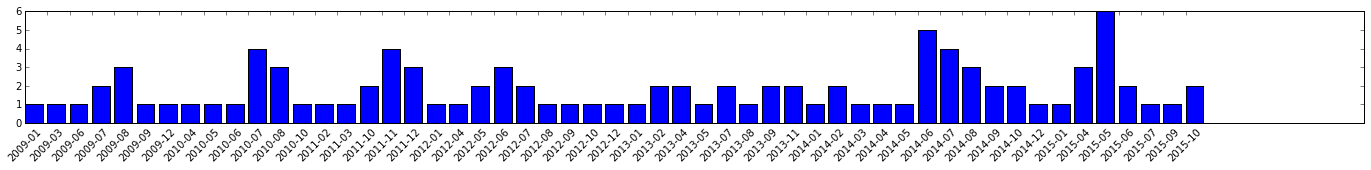

In [88]:
# Make month histogram based on total injury count
fig = plt.figure(figsize=(24, 2))
ax = plt.subplot(111)
ax.bar(range(len(xs)), ys)
ax.set_xticks(np.arange(len(xs)))
ax.set_xticklabels(xs, rotation=45);

In [89]:
# Make line graphs based on various injury counts

In [113]:
grouped_nyc_traffic_injuries = sorted_nyc_traffic_injuries.groupby(['Year', 'Month']).aggregate({
    'Pedestrian Injury Count': np.sum,
    'Bike Injury Count': np.sum,
    'Motor Vehicle Occupant Injury Count': np.sum})
grouped_nyc_traffic_injuries[:3]

Bike Injury Count  Pedestrian Injury Count  \
Year Month                                               
2009 1                      0                        1   
     3                      1                        0   
     6                      0                        1   

            Motor Vehicle Occupant Injury Count  
Year Month                                       
2009 1                                        0  
     3                                        0  
     6                                        0

In [116]:
grouped_nyc_traffic_injuries.index

MultiIndex(levels=[[2009, 2010, 2011, 2012, 2013, 2014, 2015], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]],
           labels=[[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6], [0, 2, 5, 6, 7, 8, 11, 3, 4, 5, 6, 7, 9, 1, 2, 9, 10, 11, 0, 3, 4, 5, 6, 7, 8, 9, 11, 0, 1, 3, 4, 6, 7, 8, 10, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 0, 3, 4, 5, 6, 8, 9]],
           names=[u'Year', u'Month'])

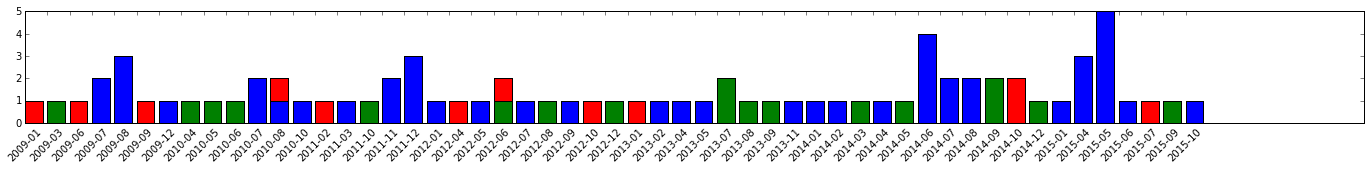

In [121]:
# Make month histogram based on total injury count
fig = plt.figure(figsize=(24, 2))
ax = plt.subplot(111)
xs = ['%d-%02d' % x for x in grouped_nyc_traffic_injuries.index]
ax.bar(range(len(xs)), grouped_nyc_traffic_injuries['Pedestrian Injury Count'].values, color='r')
ax.bar(range(len(xs)), grouped_nyc_traffic_injuries['Bike Injury Count'].values, color='g')
ax.bar(range(len(xs)), grouped_nyc_traffic_injuries['Motor Vehicle Occupant Injury Count'].values, color='b')
ax.set_xticks(np.arange(len(xs)))
ax.set_xticklabels(xs, rotation=45);

In [130]:
filtered_nyc_traffic_injuries = grouped_nyc_traffic_injuries['Pedestrian Injury Count'][grouped_nyc_traffic_injuries['Pedestrian Injury Count'] > 0]

In [133]:
filtered_nyc_traffic_injuries

Year  Month
2009  1        1
      6        1
      9        1
2010  8        2
2011  2        1
      10       1
      11       1
2012  4        1
      6        2
      10       1
2013  1        1
      2        1
      9        1
      11       1
2014  2        1
      6        1
      7        1
      10       2
2015  5        1
      7        1
      10       1
Name: Pedestrian Injury Count, dtype: int64

In [131]:
import datetime
xs = [datetime.date(y, m, 1) for y, m in filtered_nyc_traffic_injuries.index]
xs[:5]

[datetime.date(2009, 1, 1),
 datetime.date(2009, 6, 1),
 datetime.date(2009, 9, 1),
 datetime.date(2010, 8, 1),
 datetime.date(2011, 2, 1)]

In [134]:
ys = filtered_nyc_traffic_injuries.values
ys[:5]

array([1, 1, 1, 2, 1])

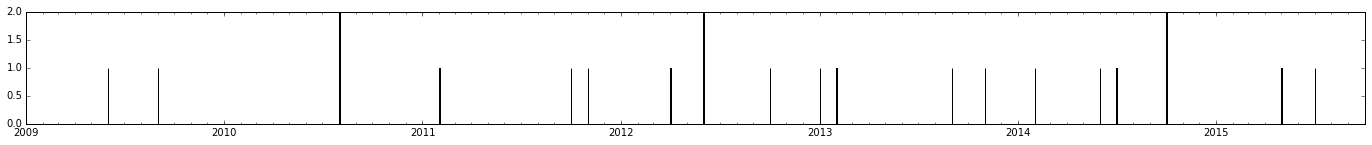

In [148]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=(24, 2))
ax = plt.subplot(111)
ax.bar(xs, ys)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

In [90]:
# Make injury count histogram

In [94]:
t = selected_nyc_traffic_injuries_table[['Pedestrian Injury Count', 'Bike Injury Count', 'Motor Vehicle Occupant Injury Count']].sum()
t

Pedestrian Injury Count                24
Bike Injury Count                      27
Motor Vehicle Occupant Injury Count    46
dtype: int64

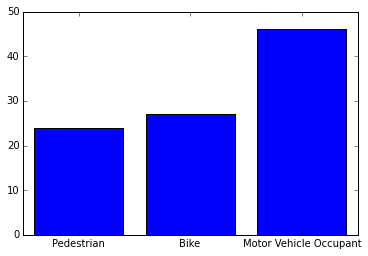

In [104]:
fig = plt.figure()
ax = plt.subplot(111)
xs = [x.replace(' Injury Count', '') for x in t.index]
ys = t.values
ax.bar(range(len(xs)), ys, align='center')
ax.set_xticks(np.arange(len(xs)))
ax.set_xticklabels(xs);

In [ ]:
# Given dates, addresses, return ranked table within bounding box
# Show histogram

In [ ]:
# Filter by bounding box
# I think we use rtree here
# but in that case, we'll have to convert lng/lat into x/y using nyc spatial reference

In [149]:
from rtree.index import Index

In [150]:
index = Index()

In [ ]:
index.insert

In [151]:
"""
for index, row in nyc_traffic_injuries_table.iterrows():
    index.insert(index, )
nyc_traffic_injuries_table[:5]
"""

,Longitude,Latitude,Year,Month,Total Injury Count,Pedestrian Injury Count,Bike Injury Count,Motor Vehicle Occupant Injury Count
0,-73.791745,40.725789,2009,1,2,1,0,1
1,-73.882429,40.844981,2009,1,1,1,0,0
2,-73.979058,40.744444,2009,1,2,2,0,0
3,-74.091345,40.602425,2009,1,1,0,0,1
4,-73.862774,40.840381,2009,1,2,0,0,2


In [ ]:
# I don't think we need to do this if we render geotable as map or geoimage heat map

In [2]:
import numpy as np

In [ ]:
# Given dates, addresses, mode of transport, return ranked routes

In [ ]:
# Call directions api

In [ ]:
# Given dates, target date, project trends for each location
# Illustrates basic trend forecasting
# Let's aggregate by year

In [ ]:
# Since accidents are a stochastic event, let's convert them into probabilities?
# No, I think counts are fine

In [34]:
import numpy as np
grouped_nyc_traffic_injuries = nyc_traffic_injuries_table.groupby(['Longitude', 'Latitude', 'Year'])
filtered_nyc_traffic_injuries_table = grouped_nyc_traffic_injuries.filter(lambda x: len(x) > 1)

In [33]:
from pandas import DataFrame
df = DataFrame({'A': np.arange(6), 'B': list('abbbcc')})
print df
print df.groupby('B').filter(lambda x: len(x) > 1)
print df.groupby('B').groups

   A  B
0  0  a
1  1  b
2  2  b
3  3  b
4  4  c
5  5  c
   A  B
1  1  b
2  2  b
3  3  b
4  4  c
5  5  c
{'a': [0], 'c': [4, 5], 'b': [1, 2, 3]}


In [23]:
nyc_traffic_injuries_table['Year'].max()

2015

In [24]:
nyc_traffic_injuries_table['Year'].min()

2009

In [31]:
xs = ['%d%02d' % (y, m) for y, m in nyc_traffic_injuries_table[['Year', 'Month']].values]

In [32]:
min(xs)

'200901'

In [33]:
max(xs)

'201510'

In [1]:
from pandas import DataFrame, Period
df = DataFrame([
    (Period(year=2009, month=1, freq='M'), 10),
    (Period(year=2009, month=4, freq='M'), 5),
    (Period(year=2009, month=11, freq='M'), 8),
], columns=['Period', 'Count'])
df = df.set_index('Period')
df

,Count
Period,
2009-01,10
2009-04,5
2009-11,8


In [15]:
df = df.resample('M', 'sum').fillna(0)
df

,Count
Period,
2009-01,10
2009-02,0
2009-03,0
2009-04,5
2009-05,0
2009-06,0
2009-07,0
2009-08,0
2009-09,0


In [19]:
t = df.index[0]

In [21]:
t.to_timestamp().value

1230768000000000000

In [22]:
xs = [x.to_timestamp().value for x in df.index]
xs

[1230768000000000000,
 1233446400000000000,
 1235865600000000000,
 1238544000000000000,
 1241136000000000000,
 1243814400000000000,
 1246406400000000000,
 1249084800000000000,
 1251763200000000000,
 1254355200000000000,
 1257033600000000000]

In [26]:
len(xs)

11

In [23]:
df.values

array([[ 10.],
       [  0.],
       [  0.],
       [  5.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  0.],
       [  8.]])

In [27]:
len(df.values)

11

In [28]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit([[x] for x in xs], df.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
model.predict(1257033690000000009)

array([[ 1.194166]])

In [4]:
x = df.resample('3MS', 'sum')
x = x.fillna(0)
x

,Count
Period,
2009-01-01,10
2009-04-01,5
2009-07-01,0
2009-10-01,8


In [6]:
t = x.index[0]

In [9]:
x.index[2].value

1246406400000000000

In [63]:
df.resample?

In [55]:
df.resample?

In [35]:
Period?

In [2]:
grouped_nyc_traffic_injuries = nyc_traffic_injuries_table.groupby(['Longitude', 'Latitude'])
filtered_nyc_traffic_injuries_table = grouped_nyc_traffic_injuries.filter(lambda x: len(x) > 2)

In [2]:
filtered_nyc_traffic_injuries_table.groupby(['Longitude', 'Latitude']).groups;

NameError: name 'filtered_nyc_traffic_injuries_table' is not defined

In [3]:
import numpy as np
yearly_nyc_traffic_injuries_table = filtered_nyc_traffic_injuries_table.groupby(['Longitude', 'Latitude', 'Year']).aggregate({'Total Injury Count': np.sum})
yearly_nyc_traffic_injuries_table[:6]

NameError: name 'filtered_nyc_traffic_injuries_table' is not defined

In [76]:
from sklearn.linear_model import LinearRegression
models = []
for (longitude, latitude), indices in filtered_nyc_traffic_injuries_table.groupby(['Longitude', 'Latitude']):
    pass

In [7]:
g = filtered_nyc_traffic_injuries_table.groupby(['Longitude', 'Latitude'])
key, indices = g.groups.items()[0]

In [9]:
filtered_nyc_traffic_injuries_table.ix[indices]

,Longitude,Latitude,Year,Month,Total Injury Count,Pedestrian Injury Count,Bike Injury Count,Motor Vehicle Occupant Injury Count
12970,-73.953128,40.71142,2014,1,1,1,0,0
23146,-73.953128,40.71142,2012,10,1,0,1,0
28325,-73.953128,40.71142,2009,11,1,0,0,1
84683,-73.953128,40.71142,2012,4,1,0,0,1
139334,-73.953128,40.71142,2009,8,1,0,0,1
162533,-73.953128,40.71142,2012,9,1,0,1,0


In [13]:
import datetime
d = datetime.date(2000, 1, 1)

In [16]:
2014 * 12 + 1  # Months since 0 A.D.

24169

In [64]:
MultiIndex.from_arrays?

In [62]:
from pandas import MultiIndex
MultiIndex.from_tuples(filtered_nyc_traffic_injuries_table[['Longitude', 'Latitude', 'Year', 'Month']].values, names=['Longitude', 'Latitude', 'Year', 'Month'])

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

In [51]:
grouped_nyc_traffic_injuries = filtered_nyc_traffic_injuries_table.groupby(['Longitude', 'Latitude', 'Year', 'Month'])
grouped_nyc_traffic_injuries.aggregate(np.sum)

Total Injury Count  Pedestrian Injury Count  \
Longitude  Latitude  Year Month                                                
-74.246903 40.509045 2013 1                       1                        1   
                          2                       1                        0   
                          5                       1                        1   
                          11                      3                        0   
-74.243741 40.509992 2010 2                       1                        1   
                          5                       1                        1   
                          6                       1                        0   
                          9                       1                        1   
-74.240543 40.517701 2010 2                       1                        0   
                          4                       1                        0   
                          7                       1                        0   
-74.239372 40.528224 2012 4                       1                        0   
                          6                       1                        0   
                          7                       3                        0   
                          8                       1                        0   
-74.238969 40.532751 2011 4                       1                        0   
                          11                      1                        0   
                          12                      2                        0   
-74.237395 40.538352 2010 1                       2                        2   
                          4                       1                        0   
                          6                       1                        0   
-74.234780 40.527948 2011 3                       2                        0   
                          6                       1                        0   
                          10                      1                        0   
-74.232822 40.516337 2014 6                       3                        0   
                          8                       1                        0   
                          12                      1                        0   
-74.230228 40.527666 2011 5                       2                        1   
                          6                       2                        0   
                          7                       3                        0   
...                                             ...                      ...   
-73.707074 40.749610 2012 2                       1                        0   
                          7                       1                        0   
                          8                       1                        0   
-73.706298 40.750025 2011 7                       2                        0   
                          11                      1                        0   
                          12                      1                        0   
                     2013 1                       1                        0   
                          9                       1                        1   
                          12                      5                        0   
-73.705575 40.737923 2013 1                       3                        1   
                          2                       1                        0   
                          4                       1                        0   
                          12                      3                        0   
-73.705372 40.748021 2013 3                       2                        0   
                          6                       1                        0   
                          9                       1                        0   
-73.704148 40.734079 2011 1                       2                        0   
                          9      

In [23]:
grouped_nyc_traffic_injuries_table = nyc_traffic_injuries_table.groupby(['Longitude', 'Latitude', 'Year'])

In [36]:
aggregated_nyc_traffic_injuries = filtered_nyc_traffic_injuries_table.groupby(['Longitude', 'Latitude', 'Year']).aggregate({'Total Injury Count': np.sum})
aggregated_nyc_traffic_injuries[:10]

Total Injury Count
Longitude  Latitude  Year                    
-74.252324 40.505639 2014                   2
-74.251830 40.502775 2010                   2
                     2011                   2
-74.246903 40.509045 2013                   6
-74.245747 40.514711 2009                   2
-74.245313 40.511791 2010                   3
                     2011                   2
-74.243741 40.509992 2010                   4
                     2012                   3
-74.241773 40.514056 2012                   4

In [7]:
g = nyc_traffic_injuries_table[:20].groupby(['Longitude', 'Latitude', 'Year'])
g

In [11]:
grouped.filter(lambda x: len(x) > 1)

NameError: name 'grouped' is not defined

In [ ]:
# We should ideally show geo heat map here

In [ ]:
# Find most dangerous center
# Illustrates minimizing a loss function

In [ ]:
# Find safest route without google directions
# Population z = f(x, y) by adding a gaussian at each accident spot, with radius proportional to number of accidents
# optimize path using optimization function, through X waypoints, where we move each of the waypoints
# in other words, we optimize the location of each waypoint
# the loss function is minimizing z and total distance
# this sounds like an obstacle avoidance algorithm
# not sure if it's really appropriate here though

In [ ]:
import pandas
print pandas.__version__

In [ ]:
from pandas import DataFrame
table = DataFrame([[1, 2], [3, 4]], columns=['A', 'B'])
table.groupby('A').sum()

In [ ]:
# Make month histogram based on total injury count
fig = plt.figure(figsize=(7, 20))
ax = plt.subplot(111)
ax.barh(xrange(len(months)), pedestrians, color='r', align='center')
ax.barh(xrange(len(months)), bikes, color='g', align='center')
ax.barh(xrange(len(months)), vehicles, color='b', align='center')
ax.set_yticks(xrange(len(months)))
ax.set_yticklabels(months)
ax.axis('tight');